In [1]:
# Cell 1: Import libraries and set random seeds for reproducibility
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import cv2
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries imported and seeds set!")


✅ Libraries imported and seeds set!


In [2]:
# Cell 2: Load dataset metadata and create train, validation, and test splits
# Adjust file paths according to your Kaggle dataset structure.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Read CSV files
labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

# Merge metadata on patientId and map targets to string labels
merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

# Split data: 80% train, 20% validation (or create a test set if desired)
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=SEED, stratify=labels_simple['Target'])
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 21347
Validation samples: 5337


In [3]:
# Cell 3: Define image loading and preprocessing function
# This function loads a DICOM image, normalizes, resizes to (224,224), and converts it to a 3-channel RGB image.
def load_preprocess_dicom(dicom_path, img_size=(224, 224)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize pixel values to [0,1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize image
    img_resized = cv2.resize(img_norm, img_size)
    # Convert grayscale to RGB by stacking the channel three times
    img_rgb = np.stack([img_resized] * 3, axis=-1)
    return img_rgb

# Test the function on a sample image from the training set
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape (should be 224x224x3):", sample_img.shape)


✅ Sample image shape (should be 224x224x3): (224, 224, 3)


In [4]:
# Cell 4: Create data generators for train and validation
def data_generator(df, batch_size=64, img_size=(224, 224), infinite=True):
    def gen():
        if infinite:
            # Infinite loop: shuffle each epoch
            while True:
                shuffled_df = df.sample(frac=1).reset_index(drop=True)
                for _, row in shuffled_df.iterrows():
                    patient_id = row['patientId']
                    label = 1 if row['Target'] == 'Pneumonia' else 0
                    dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                    img = load_preprocess_dicom(dicom_path, img_size)
                    yield img, label
        else:
            # Finite generator: iterate over the DataFrame once
            for _, row in df.iterrows():
                patient_id = row['patientId']
                label = 1 if row['Target'] == 'Pneumonia' else 0
                dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                img = load_preprocess_dicom(dicom_path, img_size)
                yield img, label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 3), ())
    )
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 64
train_ds = data_generator(train_df, batch_size=BATCH_SIZE, infinite=True)
val_ds = data_generator(val_df, batch_size=BATCH_SIZE, infinite=False)

print("✅ Data generators created with batch size:", BATCH_SIZE)


✅ Data generators created with batch size: 64


In [5]:
# Cell 5: Build a transfer learning model with frozen base layers
# Choose between ResNet50 and ResNet101 by setting MODEL_TYPE to 'resnet50' or 'resnet101'
MODEL_TYPE = 'resnet50'  # Change to 'resnet101' if desired

if MODEL_TYPE.lower() == 'resnet50':
    from tensorflow.keras.applications import ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
elif MODEL_TYPE.lower() == 'resnet101':
    from tensorflow.keras.applications import ResNet101
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224,224,3))
else:
    raise ValueError("MODEL_TYPE must be either 'resnet50' or 'resnet101'.")

# Freeze the base model layers so they are not updated during training
base_model.trainable = False

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# Cell 6: Compute class weights to counter class imbalance
y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}
print("✅ Class weights:", class_weights)


✅ Class weights: {0: 0.6454314567333858, 1: 2.219022869022869}


In [7]:
# Cell 7: Define callbacks for training
# Using EarlyStopping and ReduceLROnPlateau to monitor validation loss and adjust training accordingly.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("✅ Callbacks defined.")


✅ Callbacks defined.


In [8]:
# Cell 8: Train the transfer learning model with frozen layers
# Calculate steps_per_epoch as the number of training samples divided by batch size.
steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch)

EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,  # Ensures one full pass over the training set per epoch
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Steps per epoch: 334
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.5319 - loss: 0.7061

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


334/334 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.5318 - loss: 0.7061 - val_accuracy: 0.5010 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 311s 933ms/step - accuracy: 0.4514 - loss: 0.6946 - val_accuracy: 0.7748 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 321s 965ms/step - accuracy: 0.6254 - loss: 0.6966 - val_accuracy: 0.3189 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 327s 982ms/step - accuracy: 0.4850 - loss: 0.6893 - val_accuracy: 0.2468 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 327s 981ms/step - accuracy: 0.4256 - loss: 0.6877 - val_accuracy: 0.7744 - val_loss: 0.6350 - learning_rate: 0.0010
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 297s 892ms/step - accuracy: 0.4505 - loss: 0.6804 - val_accuracy: 0.6359 - val_loss: 0.6648 - learning_rate: 0.0010
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 287s 861ms/step - accuracy: 0.4643 - l

84/84 ━━━━━━━━━━━━━━━━━━━━ 64s 617ms/step - accuracy: 0.7773 - loss: 0.6336
Validation Loss: 0.6350, Validation Accuracy: 0.7744


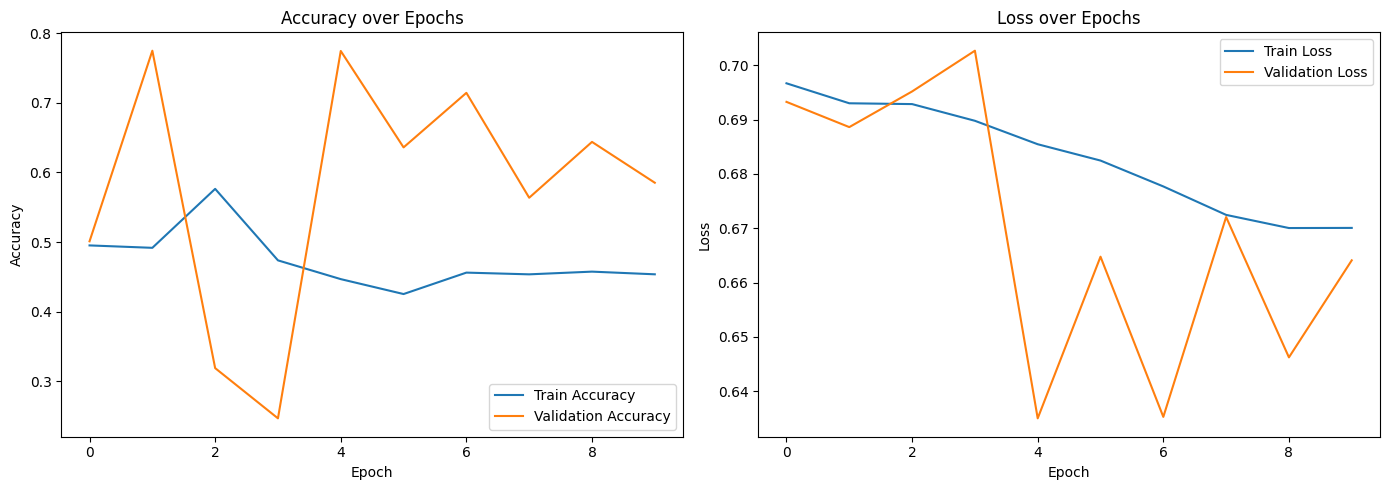

In [9]:
# Cell 9: Evaluate the model on the validation set and plot learning curves
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━

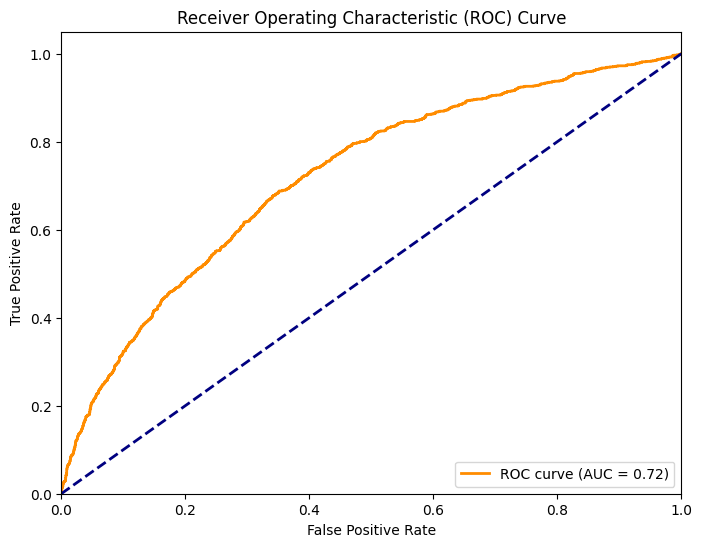

In [10]:
# Cell 8: Evaluate model performance using multiple metrics
# This cell computes accuracy, precision, recall, confusion matrix, F1-score, and plots the ROC curve along with AUC.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, f1_score, roc_curve, auc
)

# Collect true labels and model predictions from the validation dataset
y_true = []
y_pred = []
y_scores = []  # For ROC curve: the predicted probabilities

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    # Convert probabilities to binary predictions (threshold of 0.5)
    y_pred.extend((preds > 0.5).astype("int32").flatten())
    y_scores.extend(preds.flatten())

# Compute evaluation metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision: {:.2f}".format(prec))
print("Recall (Sensitivity): {:.2f}".format(rec))
print("F1-Score: {:.2f}".format(f1))
print("Confusion Matrix:\n", cm)
print("AUC: {:.2f}".format(roc_auc))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
